In [ ]:
# as you can see current ram is 12GB only, to increase it run below code

In [ ]:
#i = []
#while True:
#  i.append(i)

In [ ]:
# wait for few minutes, after that you will get a prompt that your notebook got crashed, do you want to increase ram ?

In [ ]:
# in the prompt click - yes

In [ ]:
# as you see the ram increase from 12GB to 25GB

In [ ]:
#thanks for watching, keep learning 

**NOTE**: PLease allow your browser to allow show pop-ups by sites as show below 

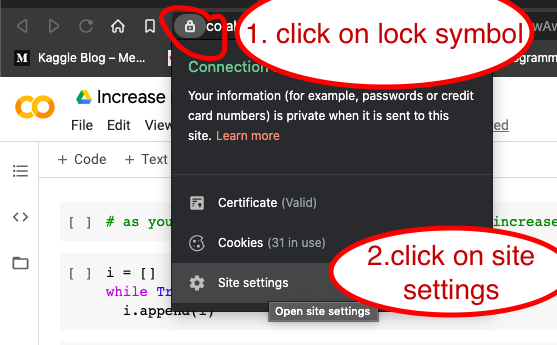

In [ ]:
#step-1

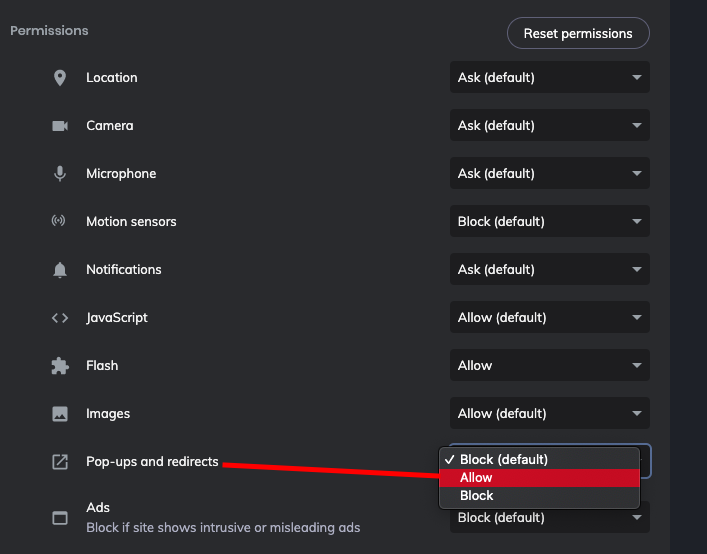

In [ ]:
#step-2

In [ ]:
!pip install transformers

!pip install torch torchvision

!pip install tensorboardX

!pip install python-Levenshtein

!pip install tensorflow

!pip install tqdm

!pip install fuzzywuzzy

     |████████████████████████████████| 2.6 MB 34.0 MB/s 
     |████████████████████████████████| 636 kB 46.6 MB/s 
     |████████████████████████████████| 3.3 MB 48.8 MB/s 
     |████████████████████████████████| 895 kB 46.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 124 kB 31.7 MB/s 
     |████████████████████████████████| 50 kB 5.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149871 sha256=3c01f2d67fa73fa95b2d9a125c935534d2057e8a904d623cc06c3a0f732485fa
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
# CONEXIÓN A DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys

sys.path.append('/content/drive/My Drive/Datitos/Proyecto_Final/')

sys.path.append('/content/drive/My Drive/Datitos/Proyecto_Final/datasets/indomain_train/')
sys.path.append('/content/drive/My Drive/Datitos/Proyecto_Final/datasets/indomain_val/')
sys.path.append('/content/drive/My Drive/Datitos/Proyecto_Final/datasets/oodomain_test/')
sys.path.append('/content/drive/My Drive/Datitos/Proyecto_Final/datasets/oodomain_train/')
sys.path.append('/content/drive/My Drive/Datitos/Proyecto_Final/datasets/oodomain_val/')

sys.path.append('/content/drive/My Drive/Datitos/Proyecto_Final/save/')

%cd /content/drive/My Drive/Datitos/Proyecto_Final/
!ls

/content/drive/My Drive/Datitos/Proyecto_Final
 args.py
 convert_to_squad.py
'Copia de prueba MOE (stocastic).ipynb'
 datasets
 ngrok
 ngrok-stable-linux-amd64.zip
'Proyecto Final'
 Prueba.ipynb
'prueba MOE 1 - Increase RAM.ipynb'
'prueba MOE 2 (+ruido) - Increase RAM.ipynb'
'prueba MOE 3 (stocastic) - Increase RAM.ipynb'
'prueba MOE 4 (stocastic + extra loss) - Increase RAM.ipynb'
 __pycache__
 save
 train.py
 util.py


In [ ]:
import argparse
import json
import os
from collections import OrderedDict
import torch
import csv
import util

#import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering
from transformers import AdamW
from tensorboardX import SummaryWriter
#from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler

from tqdm import tqdm

import torch.nn as nn
import math

from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

In [ ]:
import args
import train
import util
import convert_to_squad

In [ ]:
from args import get_train_test_args

from train import get_dataset, prepare_train_data, prepare_eval_data, read_and_process, get_dataset

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
pip install GPUtil

In [ ]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


### Capa de atención de múltiples cabezales

Uno de los conceptos clave y novedosos introducidos por el documento Transformer es la *capa de atención de múltiples cabezales*. 

![](https://i.imgur.com/CwYzPgi.png)

La atención se puede considerar como ***consultas (queries)***, ***claves (keys)*** y ***valores (values)***, donde la consulta se usa junto a la clave para obtener un vector de atención (generalmente el resultado de una operación *softmax* y tiene todos los valores entre 0 y 1 que suma a 1) que luego se usa para obtener una suma ponderada de los valores.

El Transformer utiliza ***atención de producto punto escalada***, donde la consulta y la clave se combinan tomando el producto punto entre ellas, luego aplicando softmax y escalando por $d_k$ antes de finalmente multiplicar por el valor. La constante $ d_k $ es la ***dimensión de la cabeza***, `head_dim`, que explicaremos con más detalle en breve.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

Esto es similar a la ***atención de producto punto*** estándar pero escalada por $ d_k $, que según el documento se usa para evitar que los resultados de los productos punto se hagan demasiado grandes, y por lo tanto los gradientes se vuelvan demasiado pequeños.

Sin embargo, la atención de producto punto escalada no se aplica simplemente a las consultas, claves y valores. En lugar de realizar una aplicación de atención única, las consultas, claves y valores tienen su `hid_dim` dividido en ***$ h $ cabezas*** y la atención de producto punto escalada se calcula sobre todas las cabezas en paralelo. Esto significa que en lugar de prestar atención a un concepto por aplicación de atención, prestamos atención a $ h $ conceptos. Luego, volvemos a combinar las cabezas en su forma `hid_dim`.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$ W ^ O $ es la capa densa aplicada al final de la capa de atención de múltiples cabezales, que llamaremos en el código `fc_o`. $ W ^ Q, W ^ K, W ^ V $ son las capas densas que en el código llamaremos `fc_q`,` fc_k` y `fc_v`.

Recorriendo el código del módulo, primero calculamos $ QW ^ Q $, $ KW ^ K $ y $ VW ^ V $ con las capas lineales, `fc_q`, ` fc_k` y `fc_v`, para darnos ` Q`, ` K` y `V`. A continuación, dividimos el `hid_dim` de la consulta, la clave y el valor en ` n_heads` usando `.view()` y los permutamos correctamente para que se puedan multiplicar juntos. Luego calculamos la `energía` (la atención no normalizada) multiplicando ` Q` y `K` y escalando por la raíz cuadrada de` head_dim`, que se calcula como `hid_dim // n_heads`. Luego enmascaramos la energía para que no prestemos atención a ningún elemento de la secuencia que no deberíamos, luego aplicamos el softmax y dropout. A continuación, aplicamos la atención a los valores de los cabezales, `V`, antes de combinar los resultados para las ` n_heads` . Finalmente, multiplicamos este $ W ^ O $, representado por `fc_o`.

Tenga en cuenta que en nuestra implementación las longitudes de las claves y los valores son siempre los mismos, por lo tanto, cuando la matriz multiplica la salida del softmax, `attention`, con` V` siempre tendremos tamaños de dimensión válidos para la multiplicación de matrices. Esta multiplicación se lleva a cabo usando `torch.matmul` que, cuando ambos tensores son >2-dimensionales, hace una multiplicación matricial por lotes sobre las dos últimas dimensiones de cada tensor. Esto será una multiplicación de matriz por lotes con formas **[query len, key len] x [value len, head dim]**   sobre el tamaño de lote y cada cabezal que proporciona un resultado con forma **[batch size, n heads, query len, head dim]** .

Algo que parece extraño al principio es que el dropout se aplica directamente a la atención. Esto significa que lo más probable es que nuestro vector de atención no sume 1 o que prestemos toda la atención a un solo token que puede establecerse en 0 por el dropout. Estos problemas nunca se explican, ni siquiera se mencionan, en el paper, sin embargo, es lo que se hace en la [implementación oficial](https://github.com/tensorflow/tensor2tensor/) y todas las implementaciones de Transformer desde entonces, [incluido BERT](https://github.com/google-research/bert/).

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
  
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:  # CREO QUE ESTO SE USA SÓLAMENTE EN EL DECODER PARA QUE NO VEA LAS PALABRAS "SIGUIENTES"
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Capa Feed-Forward Posicional 

La otra capa presentada en el paper es la *capa feedforward posicional*. Esta capa es relativamente simple en comparación con la capa de atención de múltiples cabezales. La entrada se transforma de `hid_dim` a` pf_dim`, donde `pf_dim` suele ser mucho más grande que` hid_dim`. El Transformer original usó un `hid_dim` de 512 y un` pf_dim` de 2048. La función de activación de ReLU y el dropout se aplican antes de que se vuelva a transformar en una representación de `hid_dim`.

BERT usa la función de activación [GELU](https://arxiv.org/abs/1606.08415), que se puede usar simplemente cambiando `torch.relu` por` F.gelu`. 

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
  
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Bloque Encoder 

Los bloques Encoder son donde se encuentra toda la "magia" del Encoder. 

![](https://i.imgur.com/adzmIfx.png)

Primero pasamos la oración origen y su máscara a la *capa de atención de múltiples cabezales*, luego aplicamos dropout, una conexión residual y una capa de  [Normalización por capas](https://arxiv.org/abs/1607.06450 ). Luego lo pasamos a través de una capa feed-forward posicional y luego, nuevamente, aplicamos dropout, una conexión residual y  la capa de normalización por capas para obtener la salida de este bloque que se alimenta al siguiente bloque. Los parámetros no se comparten entre bloques.

La capa de atención de múltiples cabezales es utilizada por el bloque encoder para prestar atención a la oración origen, es decir, está calculando y aplicando atención sobre sí misma en lugar de otra secuencia, por lo que la llamamos *auto-atención*.

[Este](https://becominghuman.ai/all-about-normalization-6ea79e70894b) artículo entra en más detalles sobre la normalización de capas, pero la esencia es que normaliza los valores de las features, de manera que cada feature tiene una media de 0 y una desviación estándar de 1. Esto permite que las redes neuronales con una mayor número de capas, como el Transformer, puedan entrenar más fácilmente.

In [ ]:
class EncoderBlock(nn.Module):

        ########################################################################

    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):        

        super(EncoderBlock, self).__init__()
      
        # MultiHeadAttentionLayer::::: def __init__(self, hid_dim, n_heads, dropout, device):
        self.attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        #LA SALIDA DE MultiHeadAttentionLayer ES -> x = [batch size, query len, hid dim]
        self.norm1 = nn.LayerNorm(hid_dim)  # CREO QUE HAY QUE CREAR 2 PORQUE SE AJUSTA PARA CADA CAPA
        self.dropout = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(hid_dim)  # CREO QUE HAY QUE CREAR 2 PORQUE SE AJUSTA PARACADA CAPA
        # PositionwiseFeedforwardLayer:::: __init__(self, hid_dim, pf_dim, dropout):
        self.ffd = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

        ########################################################################
        
    def forward(self, src, src_mask):

        # Primero pasamos la oración origen y su máscara a la capa de atención de múltiples cabezales, luego aplicamos dropout, 
        # una conexión residual y una capa de Normalización por capas. 
        # Luego lo pasamos a través de una capa feed-forward posicional y luego, nuevamente, aplicamos dropout, conexión residual 
        # y la capa de normalización por capas para obtener la salida de este bloque que se alimenta al siguiente bloque. 

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 

        src_att, att = self.attention(src, src, src, src_mask)
        src_att_drop = self.dropout(src_att)
        src_att_drop_res = src_att_drop + src # LA CONEXIÓN RESIDUAL ES SUMAR LA ENTRADA A LA SALIDA
        src_att_d_r_norm = self.norm1(src_att_drop_res)  # NORMALIZACIÓN

        src_ffd = self.ffd(src_att_d_r_norm)
        src_ffd_drop = self.dropout(src_ffd)
        src_ffd_drop_res = src_ffd_drop + src_ffd  # LA CONEXIÓN RESIDUAL ES SUMAR LA ENTRADA A LA SALIDA
        # src_ffd_d_r_norm = self.norm2(src_ffd_drop_res)  # NORMALIZACIÓN
        src = self.norm2(src_ffd_drop_res)  # NORMALIZACIÓN

        ########################################################################

        return src

### Encoder MOE (Gatting Network)
En el Encoder MOE intentaremos comprimir toda la oración fuente, $ X = (x_1, ..., x_n) $, en un solo vector de contexto, $ z $. Este vector de contexto aquí ha visto todos los tokens en todas las posiciones dentro de la secuencia de entrada.

La representación del encoder después del último bloque se pasa a través de dos capas densas, fc_out1 y fc_out2 para llevar su dimensionalidad a [batch_size, cant_expertos]. 

Finalmente, mediante capa softmax asignamos los pesos que le corresponden a cada "expertos" para cada ejemplo a procesar dentro de un batch. 

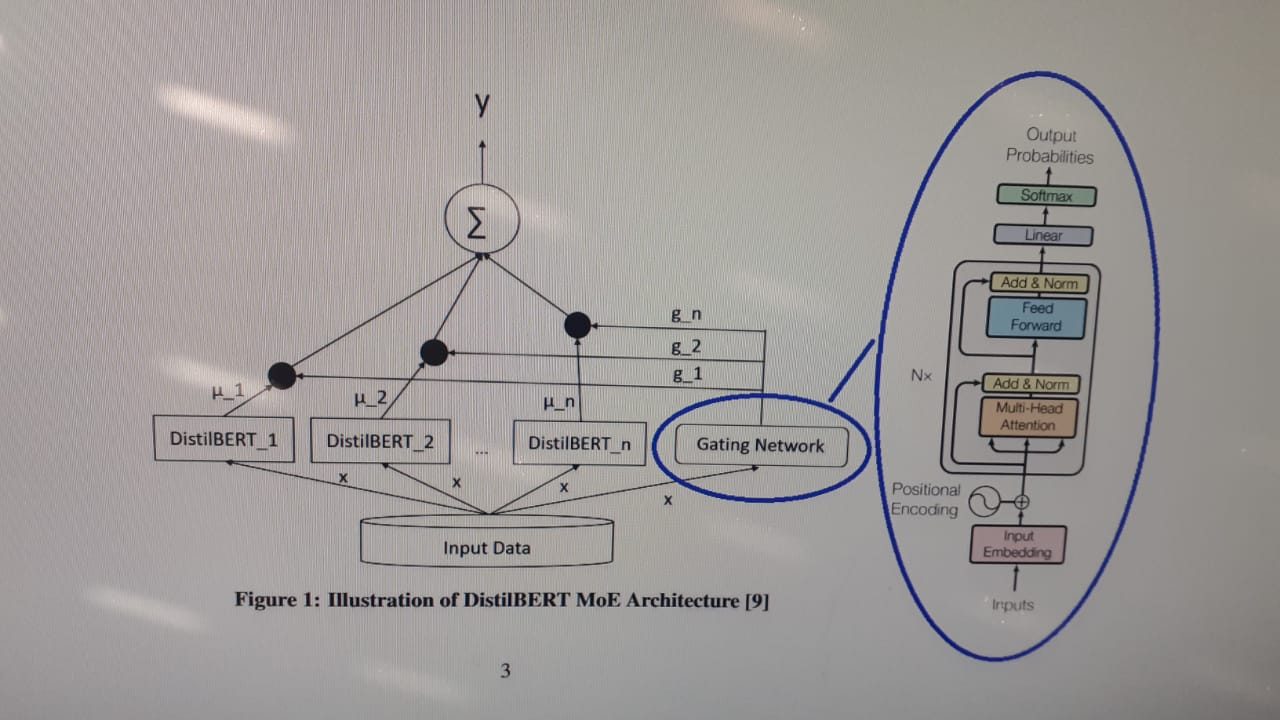

Primero, los tokens se pasan a través de una capa de embedding estándar. A continuación, como el modelo no tiene recurrencias, no tiene idea del orden de los tokens dentro de la secuencia. Resolvemos este problema usando una segunda capa de embedding llamada *capa de embedding posicional*. Esta es una capa de embedding estándar donde la entrada no es el token en sí, sino la posición del token dentro de la secuencia, comenzando con el primer token, el token `<sos>` (inicio de secuencia), en la posición 0. El embedding posicional tiene un tamaño de "vocabulario" de 100, lo que significa que nuestro modelo puede aceptar oraciones de hasta 100 tokens de longitud. Esto se puede aumentar si queremos manejar oraciones más largas.

La implementación del Transformer original del paper "Attention is All You Need" no aprende los embedding posicionales. En su lugar, utiliza una codificación posicional estática fija. Las arquitecturas modernas de Transformer, como BERT, usan embedding posicionales aprendibles en su lugar, por lo tanto, hemos decidido usarlos en este trabajo práctico. Consulte [esta](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) sección para leer más sobre la codificación posicional utilizada en el modelo Transformer original.

A continuación, el token y los embeddings posicionales se suman elemento a elemento para obtener un vector que contiene información sobre el token y también su posición en la secuencia. Sin embargo, antes de sumarlos, los embeddings de tokens se multiplican por un factor de escala que es $ \sqrt{d_{modelo}} $, donde $ d_{modelo} $ es la dimensión de las capas ocultas, `hid_dim`. Esto supuestamente reduce la variación en los embeddings y el modelo es difícil de entrenar de manera confiable sin este factor de escala. A continuación, se aplica  dropout a los embeddings combinados.

Los embeddings combinados se pasan a través de $ N $ de los ***bloques encoder***, definidos en la sección anterior, para obtener $ Z $, que luego se envía y puede ser utilizado por el decoder.

La máscara origen, `src_mask`, tiene simplemente la misma forma que la oración origen pero tiene un valor de 1 cuando el token en la oración origen no es un token` <pad> `y 0 cuando sí lo es. Esto se usa en las capas del encoder para enmascarar los mecanismos de atención de múltiples cabezales, que se usan para calcular y aplicar atención sobre la oración origen, para que el modelo no preste atención a los tokens `<pad>`, que no contienen información útil.

In [ ]:
# OJO QUIZÁS HAYA QUE CAMBIAR max_length DEPENDIENDO DE LOS TEXTOS DE LOS DATASET DE ENTRENAMIENTO)

In [ ]:
class Encoder_MOE(nn.Module):

        ########################################################################

    def __init__(self, input_dim, src_len, hid_dim, n_layers, n_heads, pf_dim, cant_expertos, dropout,
                 device, max_length = 400):

        super(Encoder_MOE, self).__init__()
               
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.pf_dim = pf_dim
        
        self.device = device
        self.max_length = max_length

        self.experts_dim = cant_expertos

        self.dropout = nn.Dropout(dropout)

        self.embedding = nn.Embedding(input_dim, hid_dim)  # input_dim es vocab_size
        
        # La implementación del Transformer original del paper "Attention is All You Need" no aprende los embedding posicionales. 
        #En su lugar, utiliza una codificación posicional estática fija. Las arquitecturas modernas de Transformer, como BERT, 
        # usan embedding posicionales aprendibles en su lugar, por lo tanto, hemos decidido usarlos en este trabajo práctico. 

        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_encoding = nn.Embedding(max_length, hid_dim)  # LO ARMO COMO UNA MLP QUE SE APRENDA
        
        self.EncoderBlocks = nn.Sequential()

        self.fc_out1 = nn.Linear(hid_dim, self.experts_dim)

        self.fc_out2 = nn.Linear(src_len, 1)

        # EncoderBlock(nn.Module)::::  def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):    
        for i in range(n_layers):
            self.EncoderBlocks.add_module("block" + str(i), EncoderBlock(hid_dim, n_heads, pf_dim, dropout, device))

        ########################################################################
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]

        #src_mask = [batch size, src len] # TENGO QUE ADECUAR LA MÁSCARA A LO QUE NECESITA EL BLOQUE DE ATENCIÓN
        src_mask = src_mask.unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        # tengo que armar un tensor con las "ubicaciones" de cada token.
        # realmente sería un a matriz con números que aumentan de de 0-src_len para cada ejemplo del batch
        batch_size = src.shape[0]
        src_len = src.shape[1]
        pos = torch.zeros(batch_size, src_len, dtype=torch.int64).to(self.device)
        ubic = torch.arange(0, src_len)
        for i in range(0, batch_size):
          pos[i] = ubic

        pos = self.pos_encoding(pos)  

        pass
        #pos = [batch size, src len]

        src = self.embedding(src)

        src = self.dropout((src * math.sqrt(self.hid_dim)) + pos)   ##agrego dropout
        pass   
        #src = [batch size, src len, hid dim]

        for blk in self.EncoderBlocks:
            src = blk(src, src_mask)
      
        pass
        #src = [batch size, src len, hid dim]
        #attention = [batch size, n heads, src len, src len]

        output = self.fc_out1(src)
        #output = [batch_size, src_len, experts_dim]

        output = output.permute(0, 2, 1)
        #output = [batch_size, experts_dim, src_len]

        output = self.fc_out2(output)
        #output = [batch_size, experts_dim, 1]
        
        output = output.squeeze(dim=2)
        #output = [batch_size, experts_dim]
        
        #print("EMI - Encoder_MOE- output.shape: ", output.shape)
        # hay que especificarle dim=2 al squeeze porque en el caso que justo quede un minibacth con 1 solo ejemplo, elimina 2 dimensiones
        # output = torch.softmax(output.squeeze(dim=2), dim = 1)  
        
        salida_max = torch.max(output, dim = 1).values
        nivel = salida_max.reshape(batch_size, -1)
        
        output = (output >= nivel) * 1
        

        #print("EMI - Encoder_MOE- SOFTMAX - output.shape: ", output.shape)

        ########################################################################        
        #EMI - Encoder_MOE- output.shape:  torch.Size([8, 3, 1])
        #EMI - Encoder_MOE- SOFTMAX - output.shape:  torch.Size([8, 3])

        return output.float()

## Entrenamiento del modelo de MEZCLA de EXPERTOS

Esta función realizará las tareas de inicialización de los modelos ("expertos"), del módulo encoder_MOE (gatting network) y optimizador.

Los modelos y el encoder_MOE se entrenarán simultáneamente.

Dado que ahora las salidas de cada modelo son pesadas según el gatting_network, debemos recalcular "loss". Y eso lo hacemos replicando el código fuente de los modelos base utilizados: 

https://huggingface.co/transformers/_modules/transformers/models/distilbert/modeling_distilbert.html#DistilBertForQuestionAnswering

Para realizar de forma práctica el pesado de las salidas de cada modelo utilizamos una combinación entre producto Hadamard y producto de matrices:

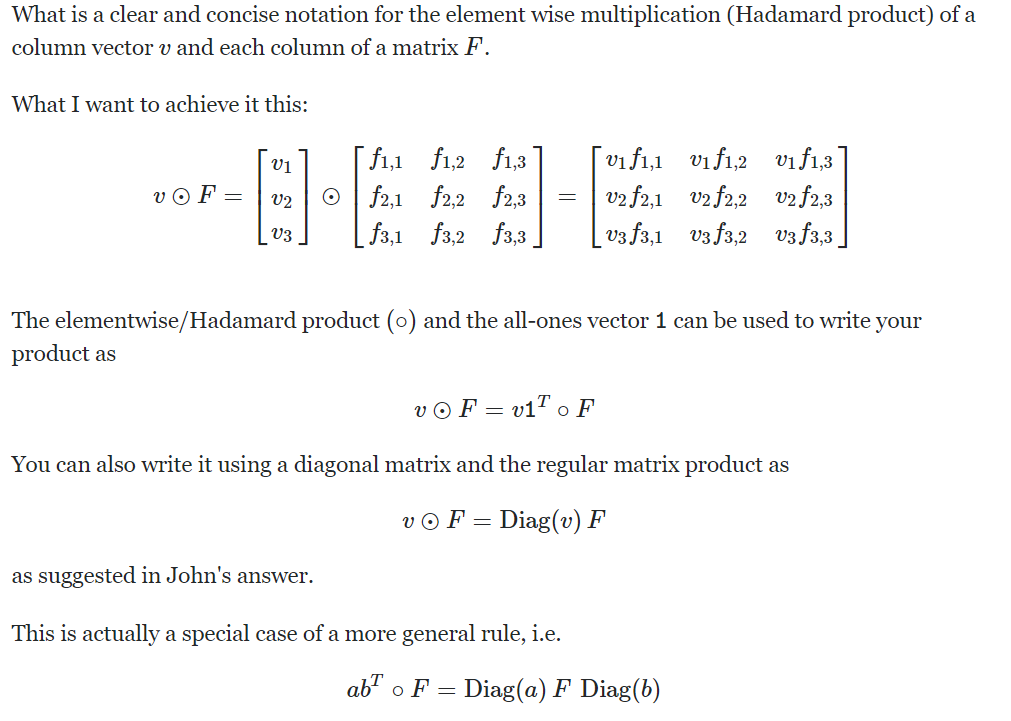



referencia: https://math.stackexchange.com/questions/3274790/notation-for-element-wise-multiplication-of-vector-and-matrix-columns

In [ ]:
def cv_squared(x):
  """The squared coefficient of variation of a sample.
  Useful as a loss to encourage a positive distribution to be more uniform.
  Epsilons added for numerical stability.
  Returns 0 for an empty Tensor.
  Args:
  x: a `Tensor`.
  Returns:
  a `Scalar`.
  """
  eps = 1e-10
  # if only num_experts = 1
  if x.shape[0] == 1:
    return torch.Tensor([0])
  return x.float().var() / (x.float().mean()**2 + eps)

In [ ]:
def train_MOE(model0, model1, model2, encoder_MOE, train_dataloader, eval_dataloader, val_dict, args, log):
  lr = args.lr
  num_epochs = args.num_epochs
  device = args.device
  eval_every = args.eval_every
  path = os.path.join(args.save_dir, 'checkpoint')
  num_visuals = args.num_visuals
  save_dir = args.save_dir
  #log = log
  visualize_predictions = args.visualize_predictions

  ii = 0  # RUIDO
  suma=0  # RUIDO
  
  if not os.path.exists(path):
    os.makedirs(path)

  model0.to(device)      # los voy a poner en device antes de llamara a la función
  model1.to(device)      # los voy a poner en device antes de llamara a la función
  model2.to(device)      # los voy a poner en device antes de llamara a la función
  encoder_MOE.to(device) # los voy a poner en device antes de llamara a la función
  
  #print("model0.device.type:", model0.device.type)
  #print("model1.device.type:", model1.device.type)
  #print("model2.device.type:", model2.device.type)
  #print("encoder_MOE.device.type:", encoder_MOE.device.type)

  #print("MEMORIA to.devide:", GPUtil.showUtilization())

  #https://discuss.pytorch.org/t/how-to-optimize-multi-models-parameter-in-one-optimizer/3603
  # se listan los parámetros de los modelos y del encoder_MOE para que los actualice
  # optim.AdamW(list(model1.parameters()) + list(model2.parameters())
  #optim = AdamW(list(model0.parameters()) + list(model1.parameters()) + list(model2.parameters()) + list(encoder_MOE.parameters()), lr=lr)

  optim = AdamW([
                 {"params": list(model0.parameters()) + list(model1.parameters()) + list(model2.parameters())},
                 {"params": encoder_MOE.parameters(), "lr": 0.0005}    
                ],
                lr=lr)


  global_idx = 0
  best_scores = {'F1': -1.0, 'EM': -1.0}
  tbx = SummaryWriter(save_dir)

  #start_logits = []   VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
  #end_logits = []     VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
  #outputs0 = []      VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
  #outputs1 = []      VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
  #outputs2 = []      VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
  #salida_softmax = []      VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
  #outputs = []      VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO

  for epoch_num in range(num_epochs):
    log.info(f'Epoch: {epoch_num}')
    with torch.enable_grad(), tqdm(total=len(train_dataloader.dataset)) as progress_bar:
      for batch in train_dataloader:

        #if ii > 0:    # RUIDO
        #  suma=torch.tensor(suma_temp).to(device) # RUIDO
        #  suma.detach() # RUIDO

        optim.zero_grad()
        model0.train()
        model1.train()
        model2.train()
        encoder_MOE.train()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        
        outputs0 = model0(input_ids, attention_mask=attention_mask)#,
                                    #start_positions=start_positions, # sacarlos para que no calcule el LOSS en cada modelo, así ahorramos
                                    #end_positions=end_positions)     # tiempo, ya que igual voy a tener que recalcular LOSS para el global
        
        outputs1 = model1(input_ids, attention_mask=attention_mask)#,
                                    #start_positions=start_positions, # sacarlos para que no calcule el LOSS en cada modelo, así ahorramos
                                    #end_positions=end_positions)     # tiempo, ya que igual voy a tener que recalcular LOSS para el global
        
        outputs2 = model2(input_ids, attention_mask=attention_mask)#,
                                    #start_positions=start_positions, # sacarlos para que no calcule el LOSS en cada modelo, así ahorramos
                                    #end_positions=end_positions)     # tiempo, ya que igual voy a tener que recalcular LOSS para el global
        
        salida_softmax = encoder_MOE(input_ids, attention_mask)


      # Para poder pesar las salidas "start" y "end" que tira cada modelo (expertos) por la salida_softax del encoder_MOE aplico lo siguiente:
      # https://math.stackexchange.com/questions/3274790/notation-for-element-wise-multiplication-of-vector-and-matrix-columns

      # start_logits (torch.FloatTensor of shape (batch_size, sequence_length)) – Span-start scores (before SoftMax).
      # end_logits (torch.FloatTensor of shape (batch_size, sequence_length)) – Span-end scores (before SoftMax).

        start_logits = ((torch.diag(salida_softmax[:,0]) @ outputs0.start_logits) + 
                        (torch.diag(salida_softmax[:,1]) @ outputs1.start_logits) +
                        (torch.diag(salida_softmax[:,2]) @ outputs2.start_logits))

        end_logits = ((torch.diag(salida_softmax[:,0]) @ outputs0.end_logits) + 
                      (torch.diag(salida_softmax[:,1]) @ outputs1.end_logits) +
                      (torch.diag(salida_softmax[:,2]) @ outputs2.end_logits))

      #### HAY QUE RECALCULAR loss AHORA, PORQUE CAMBIAMOS start_logits y end_logits GLOBALES AL PESARLOS
      ###
        # https://huggingface.co/transformers/model_doc/distilbert.html
        # https://huggingface.co/transformers/_modules/transformers/models/distilbert/modeling_distilbert.html#DistilBertForQuestionAnswering
        # Return: loss (torch.FloatTensor of shape (1,), optional, returned when labels is provided) – 
        # Total span extraction loss is the sum of a Cross-Entropy for the start and end positions.
        #   loss = outputs[0]

        total_loss = None
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions = start_positions.clamp(0, ignored_index)
            end_positions = end_positions.clamp(0, ignored_index)

            loss_fct = nn.CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2
            #loss = total_loss
      ###
      ############################


        #suma += salida_softmax.half().round().sum(0).detach()     # RUIDO
        suma = salida_softmax.half().round().sum(0)     # RUIDO
        suma.detach()    # RUIDO
        #suma_temp = suma#.tolist()    # RUIDO   # antes sumábamos cómo se distribuían los maestros a lo largo del dataset
                                                 # pero ahora lo hacemos en cada bacth, usando suma directamente
     
        ii +=1    # RUIDO
      
        aux_loss = cv_squared(suma)   # PÉRDIDA AUXILIAR PARA QUE TIENDA A USAR LA MISMA CANTIDAD DE VECES A TODOS LOS MAESTROS
        #print("SUMA:", suma)
        #print("TOTAL_LOSS:", total_loss)
        #print("AUX LOSS:", aux_loss)
        loss = total_loss + (aux_loss * 0.1)
        #print("LOSS:", loss)
        
        del suma    # RUIDO
        torch.cuda.empty_cache()    # RUIDO
        
        loss.backward()
        optim.step()
        progress_bar.update(len(input_ids))
        progress_bar.set_postfix(epoch=epoch_num, NLL=loss.item())
        tbx.add_scalar('train/NLL', loss.item(), global_idx)
        if (global_idx % eval_every) == 0:
          log.info(f'Evaluating at step {global_idx}...')
          
          # UTILIZAMOS NUESTRA PROPIA FUNCIÓN DE evaliuación
          #def evaluate_MOE(model0, model1, model2, encoder_MOE, data_loader, data_dict, args, return_preds=False, split='validation'):
          preds, curr_score = evaluate_MOE(model0, model1, model2, encoder_MOE, eval_dataloader, val_dict, args, return_preds=True)
          
          results_str = ', '.join(f'{k}: {v:05.2f}' for k, v in curr_score.items())
          log.info('Visualizing in TensorBoard...')
          for k, v in curr_score.items():
            tbx.add_scalar(f'val/{k}', v, global_idx)
          log.info(f'Eval {results_str}')
          if visualize_predictions:
              util.visualize(tbx,
                            pred_dict=preds,
                            gold_dict=val_dict,
                            step=global_idx,
                            split='val',
                            num_visuals=num_visuals)
          if curr_score['F1'] >= best_scores['F1']:
              best_scores = curr_score
              model0.save_pretrained(path + "/model0")   # guardo en carpetas, sino se sobreescribe al usar siempre "pytorch_model.bin"
              model1.save_pretrained(path + "/model1")   # guardo en carpetas, sino se sobreescribe al usar siempre "pytorch_model.bin"
              model2.save_pretrained(path + "/model2")   # guardo en carpetas, sino se sobreescribe al usar siempre "pytorch_model.bin"
              torch.save(encoder_MOE.state_dict(), path + "/encoder_MOE.pt")  # con torch.save hay asignar el nombre de archivo

        global_idx += 1
      #print("SUMA_TEMP:", suma_temp)
        #print("MEMORIA en FOR batches:", GPUtil.showUtilization())
        
  return best_scores

In [ ]:
def evaluate_MOE(model0, model1, model2, encoder_MOE, data_loader, data_dict, args, return_preds=False, split='validation'):
    device = args.device
    
    model0.eval()
    model1.eval()
    model2.eval()
    encoder_MOE.eval()
    
    #start_logits = []   VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
    #end_logits = []     VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
    #outputs0 = []      VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
    #outputs1 = []      VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
    #outputs2 = []      VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
    #salida_softmax = []      VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO
    #outputs = []      VER SI TENGO QUE INICIALIZAR VACÍO POR SI ACASO

    pred_dict = {}
    all_start_logits = []
    all_end_logits = []


    with torch.no_grad(), \
            tqdm(total=len(data_loader.dataset)) as progress_bar:
      for batch in data_loader:
        # Setup for forward
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_size = len(input_ids)
        
        # Forward
        outputs0 = model0(input_ids, attention_mask=attention_mask)   # EN eval NO LE PASAMOS LAS REALES end_positions / start_positions
        
        outputs1 = model1(input_ids, attention_mask=attention_mask)   # EN eval NO LE PASAMOS LAS REALES end_positions / start_positions
        
        outputs2 = model2(input_ids, attention_mask=attention_mask)   # EN eval NO LE PASAMOS LAS REALES end_positions / start_positions
        
        salida_softmax = encoder_MOE(input_ids, attention_mask)


      # Para poder pesar las salidas "start" y "end" que tira cada modelo (expertos) por la salida_softax del encoder_MOE aplico lo siguiente:
      # https://math.stackexchange.com/questions/3274790/notation-for-element-wise-multiplication-of-vector-and-matrix-columns

      # start_logits (torch.FloatTensor of shape (batch_size, sequence_length)) – Span-start scores (before SoftMax).
      # end_logits (torch.FloatTensor of shape (batch_size, sequence_length)) – Span-end scores (before SoftMax).

        start_logits = ((torch.diag(salida_softmax[:,0]) @ outputs0.start_logits) + 
                        (torch.diag(salida_softmax[:,1]) @ outputs1.start_logits) +
                        (torch.diag(salida_softmax[:,2]) @ outputs2.start_logits))

        end_logits = ((torch.diag(salida_softmax[:,0]) @ outputs0.end_logits) + 
                      (torch.diag(salida_softmax[:,1]) @ outputs1.end_logits) +
                      (torch.diag(salida_softmax[:,2]) @ outputs2.end_logits))

        # TODO: compute loss

        all_start_logits.append(start_logits)
        all_end_logits.append(end_logits)
        progress_bar.update(batch_size)

    # Get F1 and EM scores
    start_logits = torch.cat(all_start_logits).cpu().numpy()
    end_logits = torch.cat(all_end_logits).cpu().numpy()
    preds = util.postprocess_qa_predictions(data_dict,
                                            data_loader.dataset.encodings,
                                            (start_logits, end_logits))
    if split == 'validation':
      results = util.eval_dicts(data_dict, preds)
      results_list = [('F1', results['F1']),
                      ('EM', results['EM'])]
    else:
      results_list = [('F1', -1.0),
                      ('EM', -1.0)]
    results = OrderedDict(results_list)
    if return_preds:
      return preds, results
    return results
  

In [ ]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


### ENTRENAMIENTO y VALIDACIÓN

Ahora, para poder instanciar nuestro instanciar nuestro encoder_MOE, necesitamos primero tener instanciados los modelos base y tokenizador base y definidos nuestros datasets de entrenamiento:

In [ ]:
args = get_train_test_args()

util.set_seed(args.seed)

# python train.py --run-name baseline --do-train --train-datasets nat_questions,duorc

######  Definimos si queremos realizar un nuevo entrenamiento  XXXXXXXXXXXX
## si no es un nuevo entrenamiento tenemos que indicar en qué carpeta existente queremos seguir trabajando ###
args.do_train = True   

if args.do_train:
  carpeta_deseada =""
else:
  carpeta_deseada = 'checkpoint_MOE-04'        # indicar en qué carpeta existente queremos seguir trabajando                                           
  #checkpoint_path = os.path.join(args.save_dir, carpeta_deseada, 'checkpoint') 


###### If you would like to create these from scratch, makesure to run train.pywith the ﬂag recompute_features.
args.recompute_features = False


######  Definimos los Dataset de ENTRENAMIENTO y las carpetas de ENTRENAMIENTO y VALIDACIÓN que vamos a utilizar  XXXXXXXXXXXX
args.train_datasets = 'squad,nat_questions,newsqa,race,relation_extraction,duorc'
#args.train_datasets = 'relation_extraction,duorc'

######  Definimos el BATCH SIZE   XXXXXXXXXXXX
args.batch_size = 8


In [ ]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
######  Instanciamos los modelos base ("expertos")  XXXXXXXXXXXX
model0 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model1 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model2 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")


######  Instanciamos el Tokenizador  XXXXXXXXXXXX
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')   


#### ver memoria#
GPUtil.showUtilization()
####


######  Armamos las carpetas de destino y archivo LOG  XXXXXXXXXXXX

if not os.path.exists(args.save_dir):   # si no está creada, creo la carptea /save/
  os.makedirs(args.save_dir)            

if args.do_train:             # si es un nuevo entrenamiento creo una nueva carpeta
  args.save_dir = util.get_save_dir(args.save_dir, 'checkpoint_MOE')    
else: 
  args.save_dir = os.path.join(args.save_dir, carpeta_deseada) 

log = util.get_logger(args.save_dir, 'log_train')

log.info(f'Args: {json.dumps(vars(args), indent=4, sort_keys=True)}')

args.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # ESTO NO HACERLO ANTES SINÓ TIRA ERROR el Log:
                                                                                           # TypeError: Object of type device is not JSON serializable    
#model0.to(args.device)      # los voy a poner en device antes de llamara a la función
#model1.to(args.device)      # los voy a poner en device antes de llamara a la función
#model2.to(args.device)      # los voy a poner en device antes de llamara a la función                                                                                

######  Armamos los datasets de Entrenamiento y Validación  XXXXXXXXXXXX
log.info("Preparing Training Data...")

train_dataset, _ = get_dataset(args, args.train_datasets, args.train_dir, tokenizer, 'train')

log.info("Preparing Validation Data...")

val_dataset, val_dict = get_dataset(args, args.train_datasets, args.val_dir, tokenizer, 'val')

train_loader = DataLoader(train_dataset,
                          batch_size=args.batch_size,
                          sampler=RandomSampler(train_dataset))

val_loader = DataLoader(val_dataset,
                        batch_size=args.batch_size,
                        sampler=SequentialSampler(val_dataset))


######  Instanciamos un Encoder_MOE  XXXXXXXXXXXX
INPUT_DIM = len(tokenizer.vocab)
ENC_SRC_LEN = len(train_loader.dataset.encodings['input_ids'][0])  # todos van a tener la misma longitud (tienen padding)
HID_DIM = 256
ENC_LAYERS = 1             # 3
ENC_HEADS = 8              # 8 
ENC_PF_DIM = 512
ENC_CANT_EXPERTOS = 3
ENC_DROPOUT = 0.1
device = args.device

  #def __init__(self, input_dim, src_len, hid_dim, n_layers, n_heads, pf_dim, cant_expertos, dropout, device, max_length = 400):
encoder_MOE = Encoder_MOE(INPUT_DIM, 
                          ENC_SRC_LEN,
                          HID_DIM, 
                          ENC_LAYERS, 
                          ENC_HEADS, 
                          ENC_PF_DIM, 
                          ENC_CANT_EXPERTOS,
                          ENC_DROPOUT, 
                          device)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
[07.22.21 23:53:14] Args: {
    "batch_size": 8,
    "do_eval": false,
    "do_train": true,
    "eval": false,
    "eval_datasets": "race,relation_extraction,duorc",
    "eval_dir": "datasets/oodomain_test",
    "eval_every": 5000,
    "lr": 3e-05,
    "num_epochs": 3,
    "num_visuals": 10,
    "recompute_features": false,
    "run_name": "multitask_distilbert",
    "save_dir": "save/checkpoint_MOE-08",
    "seed": 42,
    "sub_file": "",
    "train": false,
    "train_datasets": "relation_extraction,duorc",
    "train_dir": "datasets/indomain_train",
    "val_dir": "datasets/indomain_val",
    "visualize_predictions": false
}
[07.22.21 23:53:14] Preparing Training Data...
[07.22.21 23:53:14] Preparing Validation Data...


In [ ]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  4% |  7% |


...verificamos la cantidad de parámetros de los modelos y encoder_MOE:

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model0 has {count_parameters(model0):,} trainable parameters')
print(f'The model1 has {count_parameters(model1):,} trainable parameters')
print(f'The model2 has {count_parameters(model2):,} trainable parameters')
print(f'The encoder_MOE has {count_parameters(encoder_MOE):,} trainable parameters')

The model0 has 66,364,418 trainable parameters
The model1 has 66,364,418 trainable parameters
The model2 has 66,364,418 trainable parameters
The encoder_MOE has 9,498,500 trainable parameters


...e inicializar los pesos únicamente para los parámetros de nuestro "encoder_MOE":

Xavier parece ser común entre los modelos de Transformer, así que lo usamos aquí. 

No aplicamos inicialización a los modelos Distilbert ya que en el entrenamiento Base contra el que queremos compararnos no lo aplican explícitamente (ver paper robustQA).

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
encoder_MOE.apply(initialize_weights);

In [ ]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  7% |


In [ ]:
#If you did "del some_object"
#follow it up with "torch.cuda.empty_cache()""
#del train_dataset
#torch.cuda.empty_cache()
#GPUtil.showUtilization()
#del val_dataset
#torch.cuda.empty_cache()
#GPUtil.showUtilization()

### LOOP de ENTRENAMIENTO (sólo se ejecuta si el "flag" -> args.do_train = True )

...y, finalmente, llamamos a nuestra función de Entrenamiento: "train_MOE".

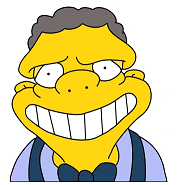



In [ ]:
args.num_epochs = 3

args.eval_every = (len(train_loader) -1)

# LLAMAMOS A LA FUNCIÓN DE ENTRENAMIENTO y VALIDACIÓN train_MOE
#def train_MOE(model0, model1, model2, encoder_MOE, train_dataloader, eval_dataloader, val_dict, args, log):
if args.do_train:
  best_scores = train_MOE(model0, model1, model2, encoder_MOE, train_loader, val_loader, val_dict, args, log)
  best_scores

  0%|          | 0/562 [00:00<?, ?it/s]

[07.22.21 23:55:21] Epoch: 0
SUMA: tensor([0., 1., 7.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.9698, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(2.0156, device='cuda:0')
LOSS: tensor(7.9854, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/539 [00:00<?, ?it/s]

[07.22.21 23:55:22] Evaluating at step 0...



100%|██████████| 539/539 [00:19<00:00, 28.27it/s]

  1%|▏         | 8/562 [00:20<01:03,  8.75it/s, NLL=7.99, epoch=0]

[07.22.21 23:55:42] Visualizing in TensorBoard...
[07.22.21 23:55:42] Eval F1: 07.12, EM: 00.79
SUMA: tensor([2., 2., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.9767, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.1875, device='cuda:0')
LOSS: tensor(6.1642, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 16/562 [00:25<09:09,  1.01s/it, NLL=6.16, epoch=0]

SUMA: tensor([3., 2., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.8812, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.0469, device='cuda:0')
LOSS: tensor(5.9281, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 24/562 [00:26<06:35,  1.36it/s, NLL=5.93, epoch=0]

SUMA: tensor([5., 0., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.8439, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.8906, device='cuda:0')
LOSS: tensor(6.7345, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 32/562 [00:27<04:50,  1.83it/s, NLL=6.73, epoch=0]

SUMA: tensor([2., 1., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.8227, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(6.4320, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 40/562 [00:28<03:37,  2.40it/s, NLL=6.43, epoch=0]

SUMA: tensor([5., 1., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.7513, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(6.3607, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▊         | 48/562 [00:29<02:46,  3.09it/s, NLL=6.36, epoch=0]

SUMA: tensor([3., 3., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.8117, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.0469, device='cuda:0')
LOSS: tensor(5.8585, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▉         | 56/562 [00:29<02:11,  3.86it/s, NLL=5.86, epoch=0]

SUMA: tensor([3., 1., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.5001, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(5.8282, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▏        | 64/562 [00:30<01:46,  4.68it/s, NLL=5.83, epoch=0]

SUMA: tensor([2., 1., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.4987, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(6.1080, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 72/562 [00:31<01:29,  5.49it/s, NLL=6.11, epoch=0]

SUMA: tensor([3., 3., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.5240, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.0469, device='cuda:0')
LOSS: tensor(5.5709, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 80/562 [00:32<01:16,  6.26it/s, NLL=5.57, epoch=0]

SUMA: tensor([2., 0., 6.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.2705, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(1.3125, device='cuda:0')
LOSS: tensor(6.5830, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 88/562 [00:33<01:08,  6.95it/s, NLL=6.58, epoch=0]

SUMA: tensor([2., 2., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.4373, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.1875, device='cuda:0')
LOSS: tensor(5.6248, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 96/562 [00:34<01:02,  7.49it/s, NLL=5.62, epoch=0]

SUMA: tensor([3., 0., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.8011, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.8906, device='cuda:0')
LOSS: tensor(5.6917, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▊        | 104/562 [00:35<00:57,  7.96it/s, NLL=5.69, epoch=0]

SUMA: tensor([4., 2., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.9213, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.1875, device='cuda:0')
LOSS: tensor(5.1088, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█▉        | 112/562 [00:35<00:54,  8.29it/s, NLL=5.11, epoch=0]

SUMA: tensor([2., 1., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.1271, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(5.7365, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▏       | 120/562 [00:36<00:51,  8.55it/s, NLL=5.74, epoch=0]

SUMA: tensor([2., 2., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.1785, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.1875, device='cuda:0')
LOSS: tensor(5.3660, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 128/562 [00:37<00:49,  8.75it/s, NLL=5.37, epoch=0]

SUMA: tensor([4., 1., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.3314, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(4.6595, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 136/562 [00:38<00:47,  8.89it/s, NLL=4.66, epoch=0]

SUMA: tensor([4., 1., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.6222, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(4.9503, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 144/562 [00:39<00:46,  9.00it/s, NLL=4.95, epoch=0]

SUMA: tensor([3., 3., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.2154, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.0469, device='cuda:0')
LOSS: tensor(4.2623, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 152/562 [00:40<00:45,  9.07it/s, NLL=4.26, epoch=0]

SUMA: tensor([0., 2., 6.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.9863, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(1.3125, device='cuda:0')
LOSS: tensor(5.2988, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 160/562 [00:41<00:44,  9.10it/s, NLL=5.3, epoch=0] 

SUMA: tensor([4., 1., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.9121, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(4.2402, device='cuda:0', grad_fn=<AddBackward0>)


 30%|██▉       | 168/562 [00:42<00:43,  9.11it/s, NLL=4.24, epoch=0]

SUMA: tensor([5., 1., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.5630, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(4.1724, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███▏      | 176/562 [00:42<00:42,  9.14it/s, NLL=4.17, epoch=0]

SUMA: tensor([4., 1., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.1819, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(4.5100, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 184/562 [00:43<00:41,  9.14it/s, NLL=4.51, epoch=0]

SUMA: tensor([3., 1., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.7013, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(4.0294, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 192/562 [00:44<00:40,  9.15it/s, NLL=4.03, epoch=0]

SUMA: tensor([2., 0., 6.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.1168, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(1.3125, device='cuda:0')
LOSS: tensor(4.4293, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 200/562 [00:45<00:39,  9.15it/s, NLL=4.43, epoch=0]

SUMA: tensor([1., 3., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.0885, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(5.4167, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 208/562 [00:46<00:38,  9.14it/s, NLL=5.42, epoch=0]

SUMA: tensor([4., 1., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.9706, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(3.2988, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 216/562 [00:47<00:37,  9.14it/s, NLL=3.3, epoch=0] 

SUMA: tensor([2., 1., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.5070, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(5.1164, device='cuda:0', grad_fn=<AddBackward0>)


 40%|███▉      | 224/562 [00:48<00:36,  9.17it/s, NLL=5.12, epoch=0]

SUMA: tensor([2., 0., 6.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.6008, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(1.3125, device='cuda:0')
LOSS: tensor(4.9133, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████▏     | 232/562 [00:49<00:36,  9.15it/s, NLL=4.91, epoch=0]

SUMA: tensor([4., 1., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.0372, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(2.3654, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 240/562 [00:49<00:35,  9.14it/s, NLL=2.37, epoch=0]

SUMA: tensor([3., 1., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.3872, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(2.7153, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 248/562 [00:50<00:34,  9.12it/s, NLL=2.72, epoch=0]

SUMA: tensor([3., 3., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.4282, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.0469, device='cuda:0')
LOSS: tensor(4.4750, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 256/562 [00:51<00:33,  9.12it/s, NLL=4.48, epoch=0]

SUMA: tensor([1., 2., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.6943, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(4.3037, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 264/562 [00:52<00:32,  9.09it/s, NLL=4.3, epoch=0] 

SUMA: tensor([3., 1., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.0112, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(3.3393, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 272/562 [00:53<00:31,  9.09it/s, NLL=3.34, epoch=0]

SUMA: tensor([3., 2., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.3003, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.0469, device='cuda:0')
LOSS: tensor(4.3472, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████▉     | 280/562 [00:54<00:31,  9.07it/s, NLL=4.35, epoch=0]

SUMA: tensor([1., 0., 7.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.4367, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(2.0156, device='cuda:0')
LOSS: tensor(4.4523, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 288/562 [00:55<00:30,  9.05it/s, NLL=4.45, epoch=0]

SUMA: tensor([4., 0., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.0054, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.7500, device='cuda:0')
LOSS: tensor(3.7554, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 296/562 [00:56<00:29,  9.05it/s, NLL=3.76, epoch=0]

SUMA: tensor([2., 1., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.8365, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(3.4459, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 304/562 [00:57<00:28,  9.06it/s, NLL=3.45, epoch=0]

SUMA: tensor([1., 2., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.3095, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(2.9189, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 312/562 [00:57<00:27,  9.07it/s, NLL=2.92, epoch=0]

SUMA: tensor([2., 1., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.2023, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(3.8117, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 320/562 [00:58<00:26,  9.05it/s, NLL=3.81, epoch=0]

SUMA: tensor([2., 2., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.2288, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.1875, device='cuda:0')
LOSS: tensor(3.4163, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 328/562 [00:59<00:25,  9.06it/s, NLL=3.42, epoch=0]

SUMA: tensor([2., 2., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(5.0337, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.1875, device='cuda:0')
LOSS: tensor(5.2212, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████▉    | 336/562 [01:00<00:24,  9.04it/s, NLL=5.22, epoch=0]

SUMA: tensor([3., 1., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.1243, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(4.4524, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 344/562 [01:01<00:24,  9.05it/s, NLL=4.45, epoch=0]

SUMA: tensor([2., 1., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.7630, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(3.3724, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 352/562 [01:02<00:23,  9.05it/s, NLL=3.37, epoch=0]

SUMA: tensor([3., 1., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.7879, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(3.1160, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 360/562 [01:03<00:22,  9.04it/s, NLL=3.12, epoch=0]

SUMA: tensor([3., 1., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.2591, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(4.5872, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 368/562 [01:04<00:21,  9.05it/s, NLL=4.59, epoch=0]

SUMA: tensor([1., 2., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.0635, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(2.6729, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 376/562 [01:04<00:20,  9.04it/s, NLL=2.67, epoch=0]

SUMA: tensor([3., 2., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.3230, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.0469, device='cuda:0')
LOSS: tensor(3.3698, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 384/562 [01:05<00:19,  9.01it/s, NLL=3.37, epoch=0]

SUMA: tensor([0., 1., 7.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.5495, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(2.0156, device='cuda:0')
LOSS: tensor(5.5651, device='cuda:0', grad_fn=<AddBackward0>)


 70%|██████▉   | 392/562 [01:06<00:18,  9.04it/s, NLL=5.57, epoch=0]

SUMA: tensor([4., 0., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.6500, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.7500, device='cuda:0')
LOSS: tensor(3.4000, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 400/562 [01:07<00:17,  9.01it/s, NLL=3.4, epoch=0] 

SUMA: tensor([3., 1., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(1.7387, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(2.0668, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 408/562 [01:08<00:17,  9.01it/s, NLL=2.07, epoch=0]

SUMA: tensor([2., 1., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.9896, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(4.5989, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 416/562 [01:09<00:16,  9.00it/s, NLL=4.6, epoch=0] 

SUMA: tensor([1., 2., 5.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.7595, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(3.3689, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 424/562 [01:10<00:15,  9.00it/s, NLL=3.37, epoch=0]

SUMA: tensor([0., 1., 7.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.4580, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(2.0156, device='cuda:0')
LOSS: tensor(5.4737, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 432/562 [01:11<00:14,  8.99it/s, NLL=5.47, epoch=0]

SUMA: tensor([0., 1., 7.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(1.9227, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(2.0156, device='cuda:0')
LOSS: tensor(3.9384, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 440/562 [01:12<00:13,  8.97it/s, NLL=3.94, epoch=0]

SUMA: tensor([3., 1., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.8167, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(4.1448, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███████▉  | 448/562 [01:12<00:12,  8.97it/s, NLL=4.14, epoch=0]

SUMA: tensor([1., 4., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(4.0425, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(4.3707, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 456/562 [01:13<00:11,  8.99it/s, NLL=4.37, epoch=0]

SUMA: tensor([5., 1., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(1.8376, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(2.4470, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 464/562 [01:14<00:10,  9.00it/s, NLL=2.45, epoch=0]

SUMA: tensor([4., 0., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.0839, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.7500, device='cuda:0')
LOSS: tensor(2.8339, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 472/562 [01:15<00:09,  9.01it/s, NLL=2.83, epoch=0]

SUMA: tensor([3., 2., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.7267, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.0469, device='cuda:0')
LOSS: tensor(2.7736, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 480/562 [01:16<00:09,  8.99it/s, NLL=2.77, epoch=0]

SUMA: tensor([1., 0., 7.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.8470, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(2.0156, device='cuda:0')
LOSS: tensor(5.8626, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 488/562 [01:17<00:08,  8.96it/s, NLL=5.86, epoch=0]

SUMA: tensor([3., 1., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.6275, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(2.9556, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 496/562 [01:18<00:07,  8.96it/s, NLL=2.96, epoch=0]

SUMA: tensor([4., 1., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.3727, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.3281, device='cuda:0')
LOSS: tensor(2.7009, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████▉ | 504/562 [01:19<00:06,  8.97it/s, NLL=2.7, epoch=0] 

SUMA: tensor([2., 3., 3.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.7379, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.0469, device='cuda:0')
LOSS: tensor(2.7848, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 512/562 [01:20<00:05,  8.95it/s, NLL=2.78, epoch=0]

SUMA: tensor([2., 4., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.2395, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.1875, device='cuda:0')
LOSS: tensor(3.4270, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 520/562 [01:21<00:04,  8.96it/s, NLL=3.43, epoch=0]

SUMA: tensor([2., 2., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(1.6126, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.1875, device='cuda:0')
LOSS: tensor(1.8001, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 528/562 [01:21<00:03,  8.95it/s, NLL=1.8, epoch=0] 

SUMA: tensor([5., 1., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.9952, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.6094, device='cuda:0')
LOSS: tensor(3.6046, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 536/562 [01:22<00:02,  8.93it/s, NLL=3.6, epoch=0]

SUMA: tensor([2., 0., 6.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(1.2771, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(1.3125, device='cuda:0')
LOSS: tensor(2.5896, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 544/562 [01:23<00:02,  8.94it/s, NLL=2.59, epoch=0]

SUMA: tensor([2., 0., 6.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(3.2291, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(1.3125, device='cuda:0')
LOSS: tensor(4.5416, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 552/562 [01:24<00:01,  8.94it/s, NLL=4.54, epoch=0]

SUMA: tensor([2., 2., 4.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(2.5823, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(0.1875, device='cuda:0')
LOSS: tensor(2.7698, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████▉| 560/562 [01:25<00:00,  8.92it/s, NLL=2.77, epoch=0]

SUMA: tensor([0., 0., 2.], device='cuda:0', dtype=torch.float16)
TOTAL_LOSS: tensor(0.3815, device='cuda:0', grad_fn=<DivBackward0>)
AUX LOSS: tensor(3.0000, device='cuda:0')
LOSS: tensor(3.3815, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/539 [00:00<?, ?it/s]

[07.22.21 23:56:47] Evaluating at step 70...



100%|██████████| 539/539 [00:20<00:00, 25.99it/s]

100%|██████████| 562/562 [01:46<00:00,  7.19it/s, NLL=3.38, epoch=0]

[07.22.21 23:57:08] Visualizing in TensorBoard...
[07.22.21 23:57:08] Eval F1: 22.95, EM: 12.20


100%|██████████| 562/562 [01:52<00:00,  4.98it/s, NLL=3.38, epoch=0]


In [ ]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 50% | 72% |


In [ ]:
# PRUEBAS ENCODER_MOE
# para ver cómo se eligieron los maestros

encoder_MOE.eval()

suma=0
i=0
for XX in val_loader:
  #print(type(XX))    
  #print(XX.keys())
  #print(len(XX))     
  if i > 0:
    suma=torch.tensor(suma_temp).to(device)
    suma.detach()
  input_ids = XX['input_ids'].to(device)
  attention_mask = XX['attention_mask'].to(device)
  salida_softmax = encoder_MOE(input_ids, attention_mask).to(device)

  input_ids.detach(), attention_mask.detach(), attention_mask.detach()

  suma += salida_softmax.half().round().sum(0)
  suma.detach()
  suma_temp = suma#.tolist()
  
  print((suma_temp))
  print((cv_squared(suma_temp)))

  del input_ids, attention_mask, salida_softmax, suma
  torch.cuda.empty_cache()
  i +=1

print(suma_temp)

tensor([4., 1., 3.], device='cuda:0', dtype=torch.float16)
tensor(0.3281, device='cuda:0')
tensor([8., 3., 5.], device='cuda:0', dtype=torch.float16)
tensor(0.2227, device='cuda:0')
tensor([11.,  6.,  7.], device='cuda:0', dtype=torch.float16)
tensor(0.1094, device='cuda:0')
tensor([16.,  7.,  9.], device='cuda:0', dtype=torch.float16)
tensor(0.1963, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


tensor([21.,  8., 11.], device='cuda:0', dtype=torch.float16)
tensor(0.2606, device='cuda:0')
tensor([23., 14., 11.], device='cuda:0', dtype=torch.float16)
tensor(0.1523, device='cuda:0')
tensor([26., 15., 15.], device='cuda:0', dtype=torch.float16)
tensor(0.1158, device='cuda:0')
tensor([29., 17., 18.], device='cuda:0', dtype=torch.float16)
tensor(0.0974, device='cuda:0')
tensor([33., 21., 18.], device='cuda:0', dtype=torch.float16)
tensor(0.1094, device='cuda:0')
tensor([37., 25., 18.], device='cuda:0', dtype=torch.float16)
tensor(0.1298, device='cuda:0')
tensor([44., 26., 18.], device='cuda:0', dtype=torch.float16)
tensor(0.2061, device='cuda:0')
tensor([49., 29., 18.], device='cuda:0', dtype=torch.float16)
tensor(0.2412, device='cuda:0')
tensor([56., 30., 18.], device='cuda:0', dtype=torch.float16)
tensor(0.3140, device='cuda:0')
tensor([60., 30., 22.], device='cuda:0', dtype=torch.float16)
tensor(0.2879, device='cuda:0')
tensor([63., 33., 24.], device='cuda:0', dtype=torch.float16

### VALIDACIÓN CON MODELOS PREENTRENADOS
Ahora, para poder validar nuestro modelos vamos a utilizar las instancias de los modelos base generadas más arriba para cargarles los pesos que hemos guardado en la carpeta_deseada.También necesitamos generar nuestros datasets de validación.

...finalmente, llamamos a nuestra función de Testeo: "evaluate_MOE".

In [ ]:
args = get_train_test_args()

util.set_seed(args.seed)

In [ ]:
# python train.py --do-eval --eval-dir datasets/oodomain_val --eval-datasets race,relation_extraction,duorc
args.do_train = False  # los seteo por si acaso 
args.do_eval = True    # los seteo por si acaso 

#save_dir_temp = args.save_dir   # guardamos la carpeta de trabajo actual (sea un nuevo entrenamiento o una carpeta existente)
#args = get_train_test_args()
#args.save_dir = save_dir_temp

######  Definimos las carpetas donde buscar nuestros modelos que hemos guardado en entrenamientos anteriores y queremos testear
carpeta_deseada = 'checkpoint_MOE-03'        # indicar en qué carpeta existente DONDE SE ENCUENTRAN LOS MODELOS
checkpoint_path = os.path.join(args.save_dir, carpeta_deseada, 'checkpoint') 
args.save_dir = os.path.join(args.save_dir, carpeta_deseada) 

###### If you would like to create these from scratch, make sure to run train.py with the ﬂag recompute_features.
args.recompute_features = False

######  Definimos los Dataset de VALIDACIÓN --- SON LOS MISMOS CON LOS QUE SE ENTRENÓ
args.train_datasets = 'race,relation_extraction,duorc'
#args.train_datasets = 'squad,nat_questions,newsqa'

######  Definimos el BATCH SIZE   XXXXXXXXXXXX
args.batch_size = 8



In [ ]:
checkpoint_path

'save/checkpoint_MOE-03/checkpoint'

In [ ]:
args.save_dir

'save/checkpoint_MOE-03'

In [ ]:
args.val_dir

'datasets/indomain_val'

In [ ]:
#args.val_dir ="datasets/oodomain_val"

Cargamos nuestros "mejores" parámetros y evaluamos en los dataset de Testeo.

In [ ]:
######  Instanciamos los modelos base ("expertos")  XXXXXXXXXXXX
#### estos ya viene instanciado de arriban (estemos en un nuevo entrenamiento o no)  
model0 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model1 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model2 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")


######  Instanciamos el Tokenizador  XXXXXXXXXXXX
#este ya viene instanciado de arriban (estemos en un nuevo entrenamiento o no)  
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')   


######  Armamos las carpetas de destino y archivo LOG  XXXXXXXXXXXX
#la carpeta ya la venimos arrastrando de más arriba
split_name = 'validation'
log = util.get_logger(args.save_dir, f'log_{split_name}')

args.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # ESTO NO HACERLO ANTES SINÓ TIRA ERROR el Log:
                                                                                           # TypeError: Object of type device is not JSON serializable    

######  Armamos los datasets de VALIDACIÓN  XXXXXXXXXXXX
log.info("Preparing Validation Data...")

val_dataset, val_dict = get_dataset(args, args.train_datasets, args.val_dir, tokenizer, split_name)

val_loader = DataLoader(val_dataset,
                        batch_size=args.batch_size,
                        sampler=SequentialSampler(val_dataset))


######  Instanciamos un Encoder_MOE  XXXXXXXXXXXX
INPUT_DIM = len(tokenizer.vocab)
ENC_SRC_LEN = len(val_loader.dataset.encodings['input_ids'][0])  # todos van a tener la misma longitud (tienen padding)
HID_DIM = 256
ENC_LAYERS = 3
ENC_HEADS = 8
ENC_PF_DIM = 512
ENC_CANT_EXPERTOS = 3
ENC_DROPOUT = 0.1
device = args.device

  #def __init__(self, input_dim, src_len, hid_dim, n_layers, n_heads, pf_dim, cant_expertos, dropout, device, max_length = 400):
encoder_MOE = Encoder_MOE(INPUT_DIM, 
                          ENC_SRC_LEN,
                          HID_DIM, 
                          ENC_LAYERS, 
                          ENC_HEADS, 
                          ENC_PF_DIM, 
                          ENC_CANT_EXPERTOS,
                          ENC_DROPOUT, 
                          device)


######  Cargamos los modelos guardados en los modelos base   XXXXXXXXXXXX
model0 = DistilBertForQuestionAnswering.from_pretrained(checkpoint_path + "/model0")  # cargo desde la carpeta correspondiente
model1 = DistilBertForQuestionAnswering.from_pretrained(checkpoint_path + "/model1")  # cargo desde la carpeta correspondiente
model2 = DistilBertForQuestionAnswering.from_pretrained(checkpoint_path + "/model2")  # cargo desde la carpeta correspondiente

encoder_MOE.load_state_dict(torch.load(checkpoint_path + "/encoder_MOE.pt"))  # cargo desde el archivo correspondiente


model0.to(args.device)
model1.to(args.device)
model2.to(args.device)
encoder_MOE.to(args.device)


#def evaluate_MOE(model0, model1, model2, encoder_MOE, data_loader, data_dict, args, return_preds=False, split='validation'):
val_preds, val_scores = evaluate_MOE(model0, model1, model2, encoder_MOE, val_loader,
                                     val_dict, 
                                     args,
                                     return_preds=True,
                                     split=split_name)

results_str = ', '.join(f'{k}: {v:05.2f}' for k, v in val_scores.items())

log.info(f'Eval {results_str}')

# Write submission file
#sub_path = os.path.join(args.save_dir, split_name + '_' + args.sub_file)
#log.info(f'Writing submission file to {sub_path}...')
#with open(sub_path, 'w', newline='', encoding='utf-8') as csv_fh:
#  csv_writer = csv.writer(csv_fh, delimiter=',')
#  csv_writer.writerow(['Id', 'Predicted'])
#  for uuid in sorted(eval_preds):
#    csv_writer.writerow([uuid, eval_preds[uuid]])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode


[07.22.21 22:05:18] Preparing Validation Data...


100%|██████████| 382/382 [00:00<00:00, 1478.78it/s]

[07.22.21 22:06:10] Eval F1: 48.33, EM: 33.51


### TESTEO
Ahora, para poder testear nuestro modelos vamos a utilizar las instancias de los modelos base generadas más arriba para cargarles los pesos que hemos guardado en la carpeta_deseada.También necesitamos generar nuestros datasets de testeo.

...finalmente, llamamos a nuestra función de Testeo: "evaluate_MOE".

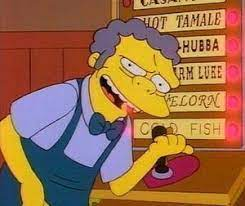

In [ ]:
# python train.py --do-eval --eval-dir datasets/oodomain_val --eval-datasets race,relation_extraction,duorc
args.do_train = False  # los seteo por si acaso 
args.do_eval = True    # los seteo por si acaso 

#save_dir_temp = args.save_dir   # guardamos la carpeta de trabajo actual (sea un nuevo entrenamiento o una carpeta existente)
#args = get_train_test_args()
#args.save_dir = save_dir_temp

######  Definimos las carpetas donde buscar nuestros modelos que hemos guardado en entrenamientos anteriores y queremos testear
checkpoint_path = os.path.join(args.save_dir, 'checkpoint') 


###### If you would like to create these from scratch, make sure to run train.py with the ﬂag recompute_features.
args.recompute_features = False


######  Definimos los Dataset de TESTEO 
args.eval_datasets = 'race,relation_extraction,duorc'
#args.eval_datasets = 'relation_extraction'



Cargamos nuestros "mejores" parámetros y evaluamos en los dataset de Testeo.

In [ ]:
######  Instanciamos los modelos base ("expertos")  XXXXXXXXXXXX
#### estos ya viene instanciado de arriban (estemos en un nuevo entrenamiento o no)  
#model0 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
#model1 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
#model2 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")


######  Instanciamos el Tokenizador  XXXXXXXXXXXX
#este ya viene instanciado de arriban (estemos en un nuevo entrenamiento o no)  
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')   


######  Armamos las carpetas de destino y archivo LOG  XXXXXXXXXXXX
#la carpeta ya la venimos arrastrando de más arriba
split_name = 'test' if 'test' in args.eval_dir else 'validation'
log = util.get_logger(args.save_dir, f'log_{split_name}')


######  Cargamos los modelos guardados en los modelos base   XXXXXXXXXXXX
model0 = DistilBertForQuestionAnswering.from_pretrained(checkpoint_path + "/model0")  # cargo desde la carpeta correspondiente
model1 = DistilBertForQuestionAnswering.from_pretrained(checkpoint_path + "/model1")  # cargo desde la carpeta correspondiente
model2 = DistilBertForQuestionAnswering.from_pretrained(checkpoint_path + "/model2")  # cargo desde la carpeta correspondiente

encoder_MOE.load_state_dict(torch.load(checkpoint_path + "/encoder_MOE.pt"))  # cargo desde el archivo correspondiente

#args.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # ESTO NO HACERLO ANTES SINÓ TIRA ERROR el Log:
                                                                                           # TypeError: Object of type device is not JSON serializable    
model0.to(args.device)
model1.to(args.device)
model2.to(args.device)
encoder_MOE.to(args.device)

######  Armamos los datasets de Testeo (evaluación)  XXXXXXXXXXXX
eval_dataset, eval_dict = get_dataset(args, args.eval_datasets, args.eval_dir, tokenizer, split_name)

eval_loader = DataLoader(eval_dataset,
                         batch_size=args.batch_size,
                         sampler=SequentialSampler(eval_dataset))

#def evaluate_MOE(model0, model1, model2, encoder_MOE, data_loader, data_dict, args, return_preds=False, split='validation'):
eval_preds, eval_scores = evaluate_MOE(model0, model1, model2, encoder_MOE, eval_loader,
                                       eval_dict, 
                                       args,
                                       return_preds=True,
                                       split=split_name)

results_str = ', '.join(f'{k}: {v:05.2f}' for k, v in eval_scores.items())

log.info(f'Eval {results_str}')

# Write submission file
#sub_path = os.path.join(args.save_dir, split_name + '_' + args.sub_file)
#log.info(f'Writing submission file to {sub_path}...')
#with open(sub_path, 'w', newline='', encoding='utf-8') as csv_fh:
#  csv_writer = csv.writer(csv_fh, delimiter=',')
#  csv_writer.writerow(['Id', 'Predicted'])
#  for uuid in sorted(eval_preds):
#    csv_writer.writerow([uuid, eval_preds[uuid]])

 23%|██▎       | 608/2694 [26:31<1:31:01,  2.62s/it]


KeyboardInterrupt: ignored

### Seguimiento del progreso en TENSORBOARD

Si estamos trabajando en Google Colab debemos instalar ***ngrok***. Esta herramienta nos permite exponer a internet una URL generada dinámicamente, la cual apunta a un servicio web que se está ejecutando en el localhost de alguna máquina. 

Para acceder a la página que nos muestra el enlace de Tensorboard que por defecto apunta al puerto local 6006 de nuestra máquina local, en lugar de al puerto de la máquina virtual que nos provee Google donde está corriendo el servicio. 

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2021-07-15 21:18:05--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.211.204.50, 52.45.37.112, 52.4.53.8, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.211.204.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  33.1MB/s    in 0.4s    

2021-07-15 21:18:06 (33.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


La siguiente celda contienen el código necesario para crear el tunel entre el puerto 6006 de la máquina virtual y una url dinámica creada en el momento.

In [ ]:
#import os
LOG_DIR = "save"         # va a buscar todos los archivos que haya en las subcarpetas dentro de save

os.makedirs(LOG_DIR, exist_ok=True)
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://d0afca7b084c.ngrok.io


En el caso que al ejecutar la celda anterior te largue un error en lugar de una url, simplemente vuelve a ejecutarla hasta que funcione.

Si todo salió bien, en este momento deberíamos poder hacer click en el enlace que arrojó la celda anterior y nos derivará a una página vacía con un mensaje de error que indica que no se pudo conectar al puerto. Esto quiere decir que el tunel fue creado correctamente, pero no hay ningún servicio corriendo en el puerto al que conecta.

Para correr el servicio, vamos a ejecutar la siguiente celda que que inicia el proceso de Tensorboard y, luego, volver a ingresar a la url que nos arrojó ngrok.



In [ ]:
!tensorboard --logdir save # Start TensorBoard

2021-07-15 21:18:35.308074: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.5.0 at http://localhost:6006/ (Press CTRL+C to quit)
W0715 21:19:09.671992 140148311799552 checkpoint_management.py:295] FailedPreconditionError: save/baseline-02/checkpoint; Is a directory
W0715 21:19:09.672298 140148311799552 checkpoint_management.py:296] save/baseline-02/checkpoint: Checkpoint ignored
W0715 21:19:09.674258 140148311799552 checkpoint_management.py:295] FailedPreconditionError: save/baseline-01/checkpoint; Is a directory
W0715 21:19:09.674405 140148311799552 checkpoint_management.py:296] save/baseline-01/checkpoint: Checkpoint igno

In [ ]:
#val_dataset, val_dict

In [ ]:
# PRUEBAS ENCODER_MOE

In [ ]:
# para ver cómo son los tensores que usamos
for XX in val_loader:
  print(type(XX))    
  print(XX.keys())
  print(len(XX))     
  break

<class 'dict'>
dict_keys(['input_ids', 'attention_mask'])
2


In [ ]:
encoder_MOE.eval()

Encoder_MOE(
  (dropout): Dropout(p=0.1, inplace=False)
  (embedding): Embedding(30522, 256)
  (pos_encoding): Embedding(400, 256)
  (EncoderBlocks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc_o): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffd): PositionwiseFeedforwardLayer(
        (fc_1): Linear(in_features=256, out_features=512, bias=True)
        (fc_2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    

In [ ]:
XX.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
XX['input_ids']

tensor([[ 101, 2029, 5088,  ...,    0,    0,    0],
        [ 101, 2029, 5088,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2154,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]])

In [ ]:
XX['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
input_ids = XX['input_ids'].to(device)
attention_mask = XX['attention_mask'].to(device)

In [ ]:
salida_softmax = encoder_MOE(input_ids, attention_mask)

In [ ]:
salida_softmax

tensor([[8.4006e-12, 5.2597e-12, 1.0000e+00],
        [8.5322e-12, 5.2139e-12, 1.0000e+00],
        [8.4911e-12, 7.4982e-12, 1.0000e+00],
        [8.8323e-12, 7.2467e-12, 1.0000e+00],
        [5.4804e-12, 7.8797e-12, 1.0000e+00],
        [6.6381e-12, 7.7797e-12, 1.0000e+00],
        [8.0416e-12, 6.8953e-12, 1.0000e+00],
        [5.4199e-12, 5.4501e-12, 1.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
salida_softmax.half().sum(0)

tensor([0., 0., 8.], device='cuda:0', dtype=torch.float16,
       grad_fn=<SumBackward1>)

In [ ]:
y=0

In [ ]:
y += salida_softmax.half().sum(0)

In [ ]:
y

tensor([ 0.,  0., 16.], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddBackward0>)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
encoder_MOE.to(device)

Encoder_MOE(
  (dropout): Dropout(p=0.1, inplace=False)
  (embedding): Embedding(30522, 256)
  (pos_encoding): Embedding(400, 256)
  (EncoderBlocks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc_o): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffd): PositionwiseFeedforwardLayer(
        (fc_1): Linear(in_features=256, out_features=512, bias=True)
        (fc_2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    

In [ ]:
len(val_loader)

In [ ]:
suma=0
i=0
for XX in val_loader:
  #print(type(XX))    
  #print(XX.keys())
  #print(len(XX))     
  input_ids = XX['input_ids']
  attention_mask = XX['attention_mask'].to(device)
  salida_softmax = encoder_MOE(input_ids, attention_mask)
  suma += salida_softmax.half().sum(0)
  if i == 100:
    break
  i +=1
  #print(salida_softmax)
  

RuntimeError: ignored